In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

[Ссылка](https://habr.com/ru/articles/687338/) на мою статью с полным описанием исследования на Habr 

### Вводная информация

Вы провели прос клиентского опыта в вашей компании. В данном случае на каждый вопрос клиент отвечает по 10 бальной шкале, где 1 - совсем неудовлетворен, а 10 - полностью удовлетворен. Вопросы разбиты на несколько тематических блоков. В начале блок основных вопросов:  
- общая удовлетворенность (CSI - Customer Satisfaction Index);
- вероятность рекомендации (для расчета NPS - Net Promoter Score);
- вероятность повторной покупки.  

Далее следуют уточняющие блоки вопросов, например, работа менеджера, качество продукции и др.   
При обработке результатов нам нужно понять как повысить общую удовлетворенность нашим продуктом (услугой), при этом мы сталкиваемся с проблемами:  
- как интерпретировать результаты опроса;
- как связать общую удовлетворенность нашим продуктом (услугой) с другими, более конкретными аспектами деятельности;
- какие из аспектов оказывают влияние и в какой мере на общую удовлетворенность.  

Мы можем анализировать результаты в ретроспективе по изменению средних баллов, можем посчитать корреляции между основным вопросами и подгруппами вопросов, но скорее всего это не приведет нас к более или менее понятным выводам.
Для ответов на вопросы может быть полезным применить факторный анализ. Он позволит увидеть степень влияния того или иного аспекта, а также сформировать группы параметров, тесно связанных между собой.

In [194]:
df = pd.read_excel('Гипотеза CSI.xlsx', sheet_name='data')

In [195]:
df.head(10)

,client_code,Общая удовлетворенность (CSI),Вероятность рекомендации (NPS),Вероятность повторной покупки,Процесс подготовки договора,Оперативность при выставлении КП,Полнота условий в типовой форме договора,Оперативность заключения договора,Оперативность согласования спецификации,Готовность предоставить техническое сопровождение,...,Процесс поставки продукции,Соблюдение сроков поставки,Доступность информации о готовности заказа,Качество погрузочных и транспортировочных работ,Качество упаковки продукции,Процесс сопровождения сделки менеджером,Доступность контактов менеджера в его рабочее время,Готовность к поиску оптимального решения,Оперативность предоставления информации,Знание области применения продукции
0,1,9,9.0,9.0,9.0,9.0,9.0,9.0,9.0,8.0,...,9.0,9.0,10.0,9.0,9.0,10.0,10.0,10.0,10.0,10.0
1,2,9,10.0,10.0,9.0,NaN,NaN,NaN,9.0,8.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,3,9,10.0,10.0,7.0,6.0,9.0,6.0,5.0,10.0,...,9.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,9.0,10.0
3,4,8,10.0,8.0,10.0,8.0,10.0,8.0,8.0,NaN,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
4,5,10,8.0,8.0,NaN,8.0,NaN,8.0,8.0,8.0,...,10.0,9.0,10.0,10.0,10.0,10.0,8.0,8.0,8.0,10.0
5,6,9,10.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,...,9.0,8.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
6,7,8,8.0,8.0,8.0,5.0,7.0,7.0,6.0,8.0,...,8.0,7.0,9.0,9.0,9.0,9.0,10.0,9.0,9.0,9.0
7,8,8,8.0,10.0,6.0,6.0,8.0,6.0,5.0,NaN,...,NaN,NaN,10.0,10.0,NaN,10.0,10.0,10.0,10.0,NaN
8,9,10,10.0,10.0,8.0,9.0,10.0,9.0,10.0,10.0,...,7.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
9,10,8,10.0,10.0,5.0,10.0,NaN,5.0,5.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


In [152]:
questions = pd.read_excel('Гипотеза CSI.xlsx', sheet_name='question')
questions = questions.fillna(' ')

Сначала посмотрим как распределились суммарные оценки респондентов. Исключим аномальных респондентов. Например, тех, кто на большинство вопросов отвечал минимальными или максимальными баллами, или вообще отказывался отвечать на большее количество вопросов. Предполагаем, что таких респондентов крайне мало, но они могут существенно исказить анализ результатов опроса. 

##### Распределение суммарных оценок каждого респондента

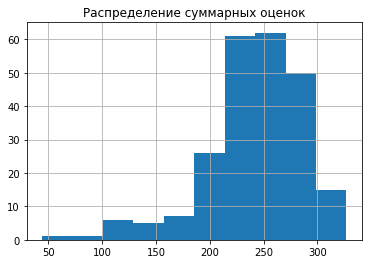

In [153]:
distribution = df.set_index('client_code').sum(axis=1)
plt.title('Распределение суммарных оценок')
distribution.hist();

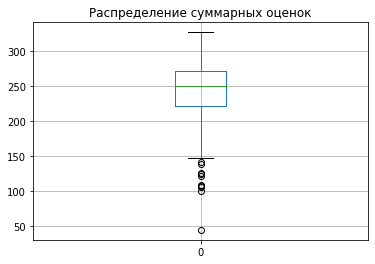

In [154]:
bp = distribution.reset_index()
plt.title('Распределение суммарных оценок')
bp.boxplot([0]);

#### поиск аномальных респондентов

На диаграмме размаха (ящика с "усами") очерчены верхния и нижняя граница ящика, что соответствуют первой (75%) третьей (25%) квантилям. Нам же нужно определить значения, выходящие за так называемые "усы", которые расположены вверху и внизу от границ ящика на расстоянии 1.5 межквартильных размахов. 

In [155]:
Q1 = distribution.quantile(0.25)
Q3 = distribution.quantile(0.75)
IQR = Q3 - Q1
print('upper limit: {:.0f}'.format(Q3+1.5*IQR))
print('lower limit: {:.0f}'.format(Q1-1.5*IQR))

upper limit: 348
lower limit: 146


Верхняя граница получаеся суммарные оценки респондентов выше 348 баллов и нижняя - 146 баллов

In [156]:
outliers = distribution[(distribution > (Q3+1.5*IQR)) | (distribution < (Q1-1.5*IQR))].reset_index()
outliers = outliers['client_code'].to_list()
print('number of outlier clients:', len(outliers))
print('share of outlier clients: {:.2%}'.format(len(outliers)/len(distribution)))

number of outlier clients: 10
share of outlier clients: 4.27%


Аномальными оказались 4%, исключим их их набора данных.

In [157]:
df = df.query('client_code != @outliers')

Изобразим корреляционную матрицу (Спирмена), чтобы наглядно посмотреть есть ли у основных вопросов явные корреляции с другими группами вопросов.

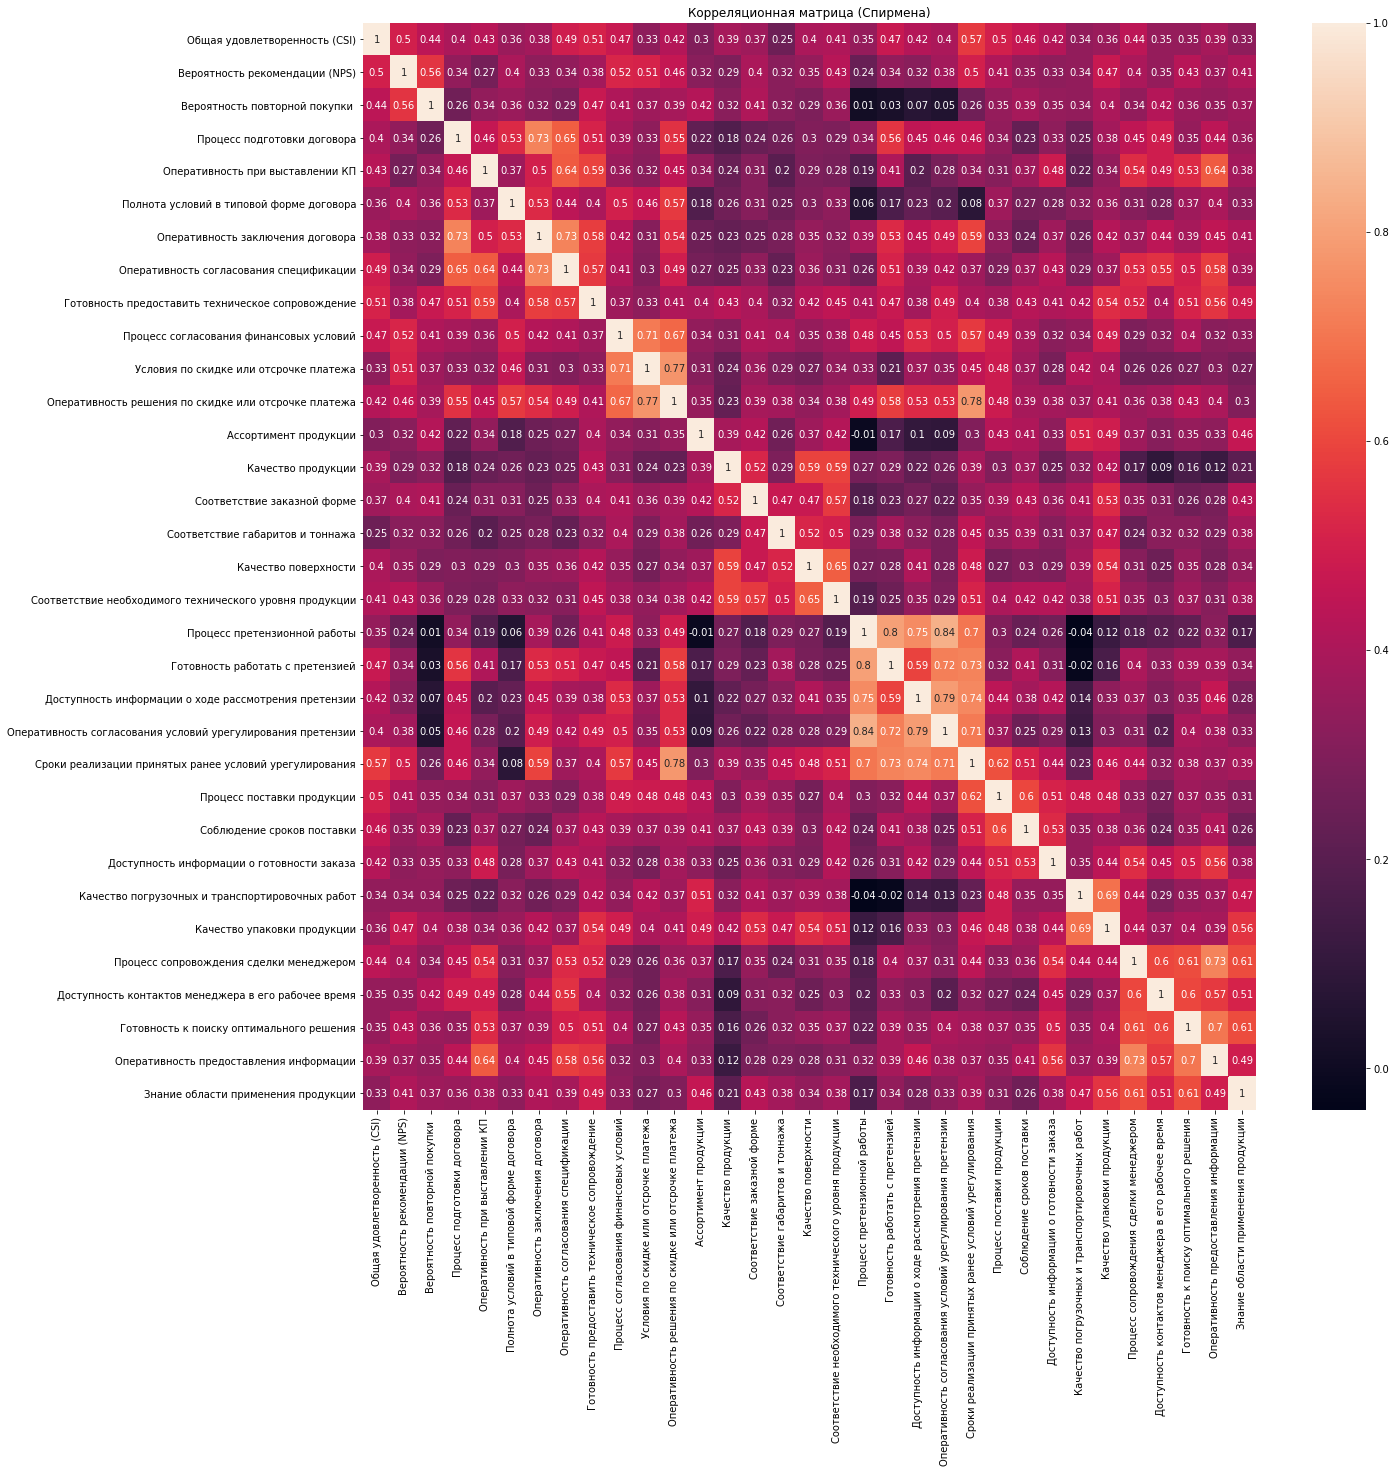

In [158]:
plt.figure(figsize=(20, 20))
plt.title('Корреляционная матрица (Спирмена)')
sns.heatmap(df.drop(columns=['client_code']).corr(method='spearman').round(2), annot=True);

In [159]:
df_corr = df.drop(columns=['client_code']) \
            .corr(method='spearman').unstack().sort_values(ascending=False).drop_duplicates().reset_index()
df_corr.columns = ['features_1', 'features_2', 'corr']
df_corr_60 = df_corr[(df_corr['corr'] >= 0.6)]
print ('доля вопросов, между которыми корреляция Спирмена 60% и более: {:.0%}'
       .format(len(df_corr_60) / len(df_corr) )) 

доля вопросов, между которыми корреляция Спирмена 60% и более: 5%


Как мы видим, например, у вопроса CSI нет явных корреляций с другими. А доля вопросов, которые между собой коррелируют на 60% и более всего 5%. Поэтому перейдем к факторному анализу. 

### Факторный анализ

Заменим отсутствующие оценки (респонденты могли отказываться отвечать на какой-то из вопросов) средним во вопросу, чтобы технически можно было провести факторный анализ.

In [160]:
df_cc = df.copy()
df_cc = df_cc.set_index('client_code').mask(df_cc == 0).fillna(df_cc.median())

Для того, чтобы определить подходят ли наши данные для факторного анализа, проверим их на критерий Бартлетта и тест Кайзера-Мейера-Олкина (КМО).

Критерий Бартлетта

In [161]:
chi_square_value, p_value = calculate_bartlett_sphericity(df_cc)
chi_square_value, p_value

(4611.652245754526, 0.0)

the p-value 0, тест статистически значим

Тест Кайзера-Мейера-Олкина (КМО)

In [162]:
kmo_all, kmo_model = calculate_kmo(df_cc)
kmo_model

0.8450885308794326

KMO более 0.85 (близко к 1), значит данные подходя для проведения факторного анализа

Наши данные подходят для факторного анализа.

Определим кол-во факторов. То есть определим количество групп вопросов, результаты которых схожи между собой.

In [163]:
fa = FactorAnalyzer()
fa.fit(df_cc)
ev, v = fa.get_eigenvalues()
ev

array([9.99955313, 3.48353376, 2.65717082, 2.01062146, 1.47540767,
       1.21703008, 1.01630207, 0.97019466, 0.91913583, 0.83630588,
       0.81516091, 0.72197036, 0.66557448, 0.59507375, 0.57851829,
       0.54356097, 0.48482209, 0.42742778, 0.41153206, 0.39001518,
       0.34143319, 0.33873975, 0.32238175, 0.28523165, 0.24437559,
       0.2380292 , 0.20200081, 0.19508718, 0.14846106, 0.14205693,
       0.12562844, 0.11444726, 0.08321594])

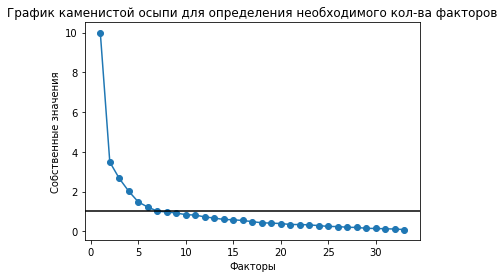

In [164]:
plt.scatter(range(1,df_cc.shape[1]+1),ev)
plt.plot(range(1,df_cc.shape[1]+1),ev)
plt.title('График каменистой осыпи для определения необходимого кол-ва факторов')
plt.xlabel('Факторы')
plt.ylabel('Собственные значения')
plt.axhline(y=1,c='k');

Выделим 6 факторов с собственным значением больше 1, то есть 6 групп вопросов.

In [165]:
fa = FactorAnalyzer()
fa.set_params(n_factors=6, rotation='varimax')
fa.fit(df_cc)
loadings = fa.loadings_
loadings = np.abs(loadings)

In [192]:
df_fa = pd.DataFrame(loadings).reset_index()
df_fa.columns=['№', 'Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6']
df_fa = (df_fa.merge(questions['question'], how='left', left_index=True, right_index=True)
         .reindex(columns=['№', 'question', 'Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6']))
df_fa

,№,question,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
0,0,Общая удовлетворенность (CSI),0.414608,0.079507,0.400066,0.166221,0.140305,0.260226
1,1,Вероятность рекомендации (NPS),0.194223,0.029485,0.366815,0.295601,0.329266,0.066278
2,2,Вероятность повторной покупки,0.269179,0.049092,0.321484,0.280336,0.270325,0.114488
3,3,Процесс подготовки договора,0.669548,0.085700,0.068009,0.328212,0.026715,0.047637
4,4,Оперативность при выставлении КП,0.670916,0.057759,0.197755,0.219115,0.013860,0.073310
5,5,Полнота условий в типовой форме договора,0.348891,0.048556,0.054264,0.510015,0.056315,0.118538
6,6,Оперативность заключения договора,0.677960,0.113345,0.001804,0.415048,0.035819,0.060623
7,7,Оперативность согласования спецификации,0.807180,0.075942,0.141341,0.277508,0.030669,0.059324
8,8,Готовность предоставить техническое сопровождение,0.403336,0.160447,0.299207,0.180682,0.144026,0.001914
9,9,Процесс согласования финансовых условий,0.127225,0.084994,0.267794,0.734851,0.223656,0.055201


In [193]:
df_fa_pivot = df_fa.pivot_table(index='question').sort_values(by=['№']).drop(columns=['№'])

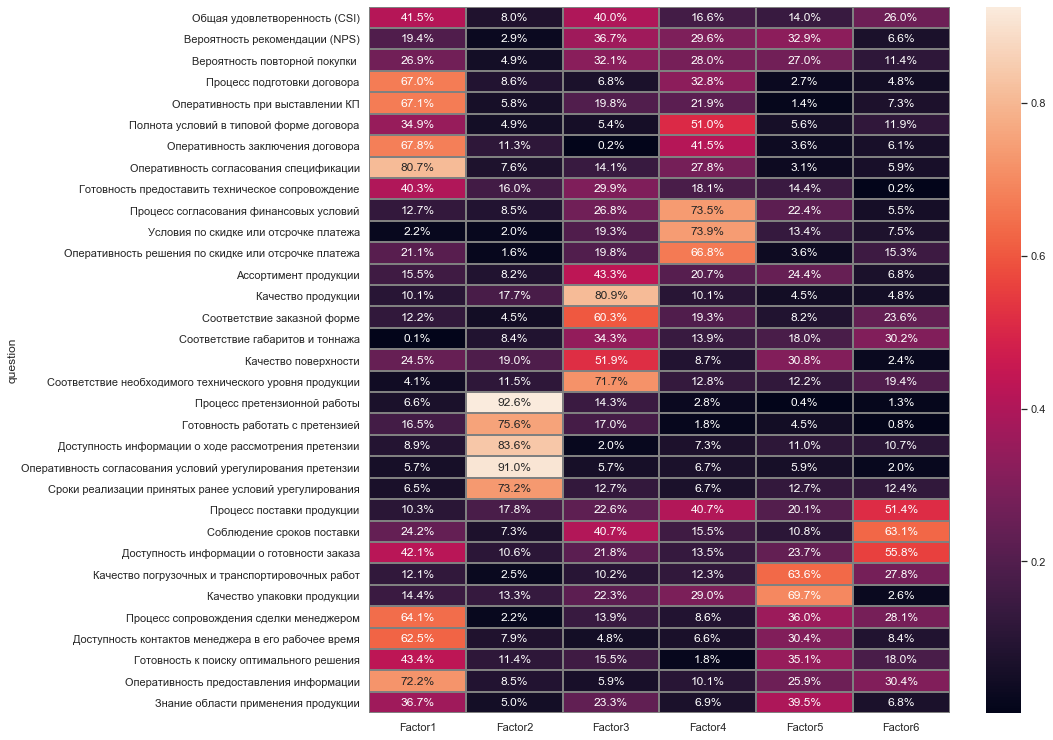

In [191]:
plt.figure(figsize=(13, 13))
sns.heatmap(df_fa_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

В результате получам таблицу, где расчитаны корреляции каждого вопроса с каждым из выделенных 6 факторов. То есть мы видим как каждый вопрос коррелирует со сформированным фактором. С помощью факторного анализа мы разделили все вопросы на группы и видим с какое влияние каждый вопрос оказывает на эту группу.

Выводы и завершение интерпритации исследования по ссылке https://habr.com/ru/articles/687338/